# Running `croptypemapper` on Colab

This notebook demonstrates how to run `croptypemapper` for inference on a single tile. The first step is to connect the notebook to Google Drive and clone the `croptypemapper` [repository](https://github.com/agroimpacts/croptypemapper), which contains the necessary code for running the model.  

Other requirements for this demonstration:

1. Two sets of files providing the predictor variables used by the model. These should be stored on a Google Drive folder under a folder name of your choosing, e.g. `/drive/content/MyDrive/data/imagery/sentinel_cubes`. 
    - One sub_folder should be `s1` or `Sentinel-1` and should contain at least three files, named: 
        - `source_s1_XXXXXX.json`
        - `source_s1_XXXXXX.npy`
        - `source_s1_XXXXXX_meta.pickle`
    
    where XXXXXX represents the identifier of a particular tile. There are three files per tile. 
    - One sub_folder should be `s2` or `Sentinel-2` and should contain at least four files: 
        - `cloudmask_s2_XXXXXX.npy`
        - `source_s2_XXXXXX.json`
        - `source_s2_XXXXXX.npy`
        - `source_s2_XXXXXX_meta.pickle`
    
    XXXXXXX represents the same tile identifier, and thus there are 4 files per tile in this folder.  

  - The code to make both sets of predictors is in the `cscdc` [repository](https://github.com/agroimpacts/cscdc).

2. At least one file in a separate folder (ideally) containing a .pth extension, which contains the pre-trained weights for the model, e.g. `/drive/content/MyDrive/data/models/croptypemapper/v0/Double_branch_stacked_biLSTM_params.pth`

3. An image produced by [`deeplearner`](https://github.com/agroimpacts/deeplearner) or equivalent model that maps crop fields. 
  - The image should be mapped to the same extent and resolution as the crop type predictions (here 550X550 pixels per tile, or about 550m on a side) 
  - The filename should encode the same tile identifier, and should ideally be kept in a different folder, e.g. `/drive/content/MyDrive/data/predictions/fields/`. 
  - The fields image should have values of 1 or more corresponding to each field (each field can have its own unique identifying integer, or just a 1). Values outside of fields should have a 0. 


The model will require a GPU instance to run, so please change the runtime type accordingly. 

# Setup

## Preparing colab and Google Drive

In [ ]:
from google.colab import drive # import drive from google colab

ROOT = "/content/gdrive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)

Follow the steps to dialog to connect your Google Drive account of choice.

Then clone the repository into the Drive directory that you want to put it in, following directions provided [here](https://towardsdatascience.com/google-drive-google-colab-github-dont-just-read-do-it-5554d5824228). You will need to create a GitHub personal access token to enable this step.  

In [5]:
# Clone github repository setup
# import join used to join ROOT path and mydrive_path
import os
from os.path import join  

# path to your project on Google Drive
mydrive_path = 'MyDrive/projects' 
# replace with your Github username 
git_username = "agroimpacts" 
# definitely replace with your
git_token = "replace_with_your_token"  
# 
# to clone deep-learning-v2-pytorch repository
repo = "croptypemapper" 
project_path = join(ROOT, mydrive_path)
repo_path = os.path.join(project_path, repo)

# It's good to print out the value if you are not sure 
print("PROJECT_PATH: ", project_path)   

# In case we haven't created the folder already; we will create a folder in the project path 
# !mkdir "{project_path}"    

#GIT_PATH = "https://{GIT_TOKEN}@github.com/{GIT_USERNAME}/{GIT_REPOSITORY}.git" this return 400 Bad Request for me
git_path = f'https:{git_token}@github.com/{git_username}/{repo}.git'
print("GIT_PATH: ", git_path)

PROJECT_PATH:  /content/gdrive/MyDrive/projects
GIT_PATH:  https:replace_with_your_token@github.com/agroimpacts/croptypemapper.git


Change the working directory to the project path, and then clone the repo if it doesn't exist, and change into the repo

In [6]:
os.chdir(project_path)
if os.getcwd() == project_path:
    print("Changed into correct directory")
    if not os.path.isdir(repo_path):
        !git clone "{GIT_PATH}" # clone the github repository'

    os.chdir(repo_path)
    !git branch

Changed into correct directory
  feature/demo_notebook
* main


## Import necessary python packages

Some extra packages need to be installed first in order for the code to run. These include `rasterio`, `boto3`, which enables subsequent AWS functionality (not yet fully enabled) and unfortunately requires a downgrade in the package `urllib3` to work, and throws a number of warnings in the process. 

In [ ]:
!pip install rasterio
!pip install boto3  # enables AWS reads
!pip install urllib3==1.25.5  # needed to prevent boto failures
!pip install tensorboardX

And then we import the necessary packages. Note the `sys.path.insert` statements, which are needed to import the necessary modules from `croptypemapper`

In [7]:
import sys 
import os
import re

# add these here to make sure the necessary modules can be loaded
root_dir = os.environ['PWD']
sys.path.insert(0, os.path.join(repo_path, 'croptypemapper/'))
sys.path.insert(0, repo_path)
# print(sys.path)

import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
import yaml

import importlib
import croptypemapper
importlib.reload(croptypemapper)
from croptypemapper.compiler import *
from croptypemapper.dataloader import *

import models
importlib.reload(models)
from models import *

# Preparing the model

With the repo and packages all installed, it is now time to set up the model to run predictions. 

## Configuration

We are configuring here the model to run inference, using pre-trained parameters. The variables needed as arguments for the model are contained in a `config` dictionary below. For command line runs, these parameters are parsed from a yaml file (see the [template](https://github.com/agroimpacts/croptypemapper/blob/main/config.yaml)). Please note the comments with entries indicating which variables need to be changed to run the demonstration. 

In [8]:
config = {

    # Model Compiler
    # location of file model parameter file on drive. Please update to 
    # match your installation.
    "init_params" : 
        "/content/gdrive/MyDrive/data/models/croptypemapper/v0/"\
        "Double_branch_stacked_biLSTM_params.pth",

    "gpus" : [0],
    "input_dims" : (4, 11),
    "LSTM_hidden_dim" : (48, 64),
    "CNN_hidden_dim" : (48, 64),
    "CNN_kernel_size" : (5, 5),
    "CNN_sequence_length" : (57, 67),
    "n_classes": 4,
    "n_LSTM_layers" : (2, 4),
    "LSTM_lyr_dropout_rate" : (0.4, 0.5),
    "CNN_lyr_dropout_rate" : (0.25, 0.45),
    "s1_weight" : 0.5,
    "branch_weights": (0.3, 0.3, 0.4),
    "batch_val": 1,
    
    # data paths
    # path to parent folder containing the two sets of Sentinel input 
    # files.  Change this to match your folders
    "root_dir": "/content/gdrive/MyDrive/data/imagery/sentinel_cubes/",
    # sub-folders holding the Sentinel 1 and Sentinel 2 inputs. Rename as needed
    # to match your folder structure
    "sources": ["s1", "s2"],
    # where outputs go for model training. Not used here but a required argument
    # for model compiling. Change as needed. 
    "working_dir": "/content/gdrive/MyDrive/working_folder/",
    # prefix in working_dir for model training outputs (also not needed)
    "out_dir": "croptypemapper_v0",
    # where you want the output predictions from the model to go.
    "prefix_out": "/content/gdrive/MyDrive/data/predictions/croptypes/v0/"
}
config

{'CNN_hidden_dim': (48, 64),
 'CNN_kernel_size': (5, 5),
 'CNN_lyr_dropout_rate': (0.25, 0.45),
 'CNN_sequence_length': (57, 67),
 'LSTM_hidden_dim': (48, 64),
 'LSTM_lyr_dropout_rate': (0.4, 0.5),
 'batch_val': 1,
 'branch_weights': (0.3, 0.3, 0.4),
 'gpus': [0],
 'init_params': '/content/gdrive/MyDrive/data/models/croptypemapper/v0/Double_branch_stacked_biLSTM_params.pth',
 'input_dims': (4, 11),
 'n_LSTM_layers': (2, 4),
 'n_classes': 4,
 'out_dir': 'croptypemapper_v0',
 'prefix_out': '/content/gdrive/MyDrive/data/predictions/croptypes/v0/',
 'root_dir': '/content/gdrive/MyDrive/data/imagery/sentinel_cubes/',
 's1_weight': 0.5,
 'sources': ['s1', 's2'],
 'working_dir': '/content/gdrive/MyDrive/working_folder/'}

## Initialize and compile the model

The next step is to initialize and compile the model, providing it with the pre-trained parameters. 

In [9]:
# Initialize the model
lstm_model = Double_branch_stacked_biLSTM(
    input_dims = config["input_dims"],
    hidden_dims = config["LSTM_hidden_dim"], 
    n_classes = config["n_classes"], 
    n_layers = config["n_LSTM_layers"], 
    dropout_rate = config["LSTM_lyr_dropout_rate"], 
    s1_weight = config["s1_weight"], 
    bidirectional = True, 
    use_layernorm = True, 
    use_batchnorm = False, 
    use_attention = False
)

Compile the model

In [ ]:
model = ModelCompiler(model=lstm_model,
                      working_dir=config["working_dir"], 
                      out_dir=config["out_dir"],
                      gpuDevices=config["gpus"],
                      br_weights = config["branch_weights"],
                      params_init=config["init_params"],
                      freeze_params=None)

----------GPU available----------
total number of trainable parameters: 0.4M
---------- Pre-trained model compiled successfully ----------


## Set up loader for predictors

In [ ]:
def load_data_pred(usage, item):
    dataset = pixelDataset(root_dir = config["root_dir"],
                           usage = "test", num_samples=None,
                           sources = config["sources"],
                           inference_index = item)
    tile = dataset.tile_id
    meta = dataset.meta
    data_loader = DataLoader(
        dataset, batch_size=config["batch_val"], shuffle = False
    )
    
    return data_loader, meta, tile

# Run predictions

Set up directories and count number of tiles to run predictions on. In this example there is just one, but this is enabled to run more. 

In [ ]:
tile_dir = os.path.join(config["root_dir"], config["sources"][0])
# print(tile_dir)
s1_fnms = [os.path.join(dirpath, f) for (dirpath, dirnames, filenames) \
           in os.walk(tile_dir) for f in filenames \
           if f.endswith(".npy")]
tile_count = len(s1_fnms)
tile_count


1

Run prediction for each tile. Each tile currently takes about 25-30 minutes to complete

In [ ]:
for i in range(tile_count):
    print(f'Loading tile {i}')
    pred_data = load_data_pred("test", int(i))
    print(f'..tile {i} loaded')

    print('..Running inference ')
    model.inference(pred_data, config["prefix_out"])


Loading tile 0
..tile 0 loaded
..Running inference 
-------------------------- Start Inference(Test) --------------------------
-------------------------- Inference finished in 0:26:35s --------------------------


## Inspect prediction results

We can first have a look at the prediction results. There are two outputs in sub-folders of the output directory that is specied. One is the "crisp" prediction, which are the predictions for which crop should be assigned to each pixel, which are coded in this example as:

- 0: Unknown crop type (blue)
- 1: Maize (not shown)
- 2: Rice (green)
- 3: Other crops (yellow)

These are shown on the left. The other output is the probability image for the classes. The probabilities for just one class is shown on the right, which is the probability that each pixel belongs to class 3 (other crops).

As you can see, these predictions, which are for the northeast tip of Ejura-Tain, are well off, which is because the model was trained with data from a different year and different area of Ghana (up in the north, with data from 2017/2018). It is also because this model was not trained with a non-crop class, so that makes it harder for it distinguish specific crops growing in fields from areas outside of fields.  

This is just for illustration, however, and the model will improve as it is given training data from this region, as well as a negative class. 

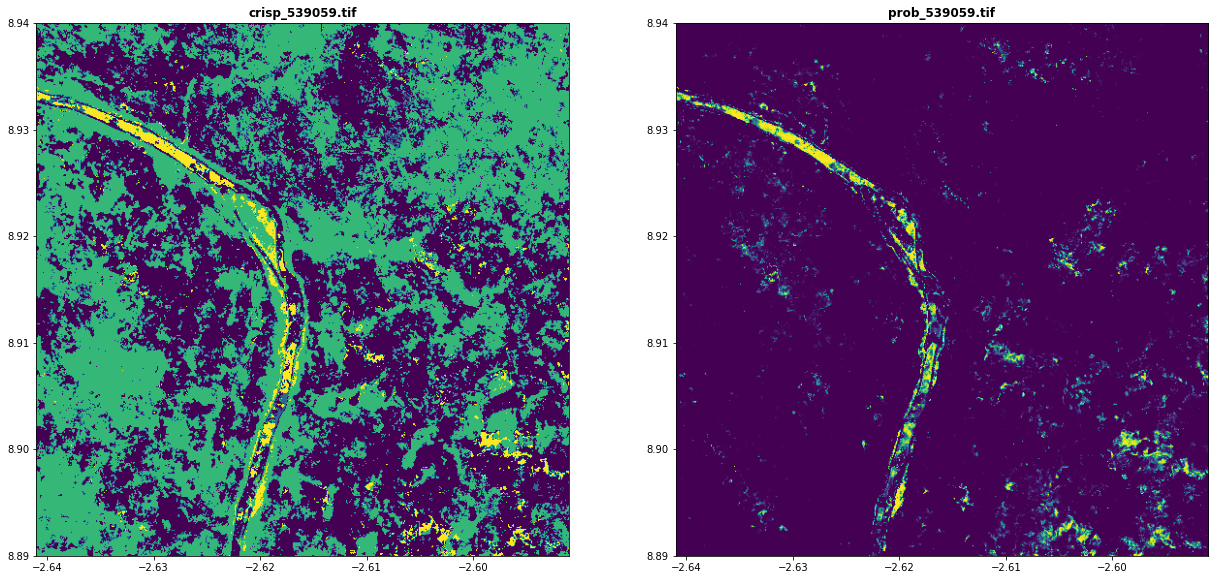

In [105]:
# note we add a filter for the specific tile ID, in case we have more tiles in 
# the directory, as we just want to show one. Change the value for tid as needed
tid = "539059"  
pred_fnames = [os.path.join(dirpath, f) for (dirpath, dirnames, filenames) \
               in os.walk(config['prefix_out']) for f in filenames \
               if f.endswith(f'{tid}.tif')]

fig, axes = plt.subplots(1, len(pred_fnames), figsize=(21,10))
for i in range(len(axes)):
    pred = rasterio.open(pred_fnames[i])
    show(pred, ax = axes[i], title = os.path.basename(pred_fnames[i]))

# Filter predictions

We will now use the field boundary maps to filter the predictions, confining them to fields detected by the `deeplearner` model, which uses higher resolution imagery. 

## Configuration

We find the field image first, using a path (stored separately from `croptypemapper`'s configuration). 


In [37]:
fld_path = os.path.join(ROOT, 'MyDrive/data/predictions/fields/')
field_fnames = [os.path.join(dirpath, f) for (dirpath, dirnames, filenames) \
                in os.walk(fld_path) for f in filenames \
                if f.endswith(".tif")]

We want to match the correct field boundary image with its corresponding croptype predictions, in this case the classified (crisp) classes.  There is only one tile in this example, but this matching will be necessary when the number of tiles predicted increases. 

In [92]:
# select just classified predictions
classified_fnames = [p for p in pred_fnames if "crisp" in p]

# match field images to classified preds
fld_match = []
for idx, fld in enumerate(field_fnames):
    tid = re.sub('\D', '', os.path.basename(fld))
    classified_fname = [cf for cf in classified_fnames if tid in cf]
    fld_match.append([fld, classified_fname[0]])
    #re.sub('\D', '', os.path.basename(field_preds[idx]))

fld_match

[['/content/gdrive/MyDrive/data/predictions/fields/v0/539059_flds.tif',
  '/content/gdrive/MyDrive/data/predictions/croptypes/v0/HardScore/crisp_539059.tif'],
 ['/content/gdrive/MyDrive/data/predictions/fields/v0/539060t_flds.tif',
  '/content/gdrive/MyDrive/data/predictions/croptypes/v0/HardScore/crisp_539060t.tif']]

## Mask predictions

Once the field images and predictions are matched, the prediction can be masked by their corresponding fields. The code below processes each matching field-crop type pair, sets to 0 any crop types predicted outside of fields, and then writes out the filtered predictions to a new geotiff. We have to specify which folder that new filtered prediction will be written to, which is specified in the path variable `filtered_path` below. This directory is created if it doesn't exist. Please specify a different path if needed. 



In [116]:
filtered_path = os.path.join(config['prefix_out'], "filtered_score")
if not os.path.exists(filtered_path):
    os.mkdir(filtered_path)

for idx, matches in enumerate(fld_match):
  # read in values from field layer
  with rasterio.open(matches[0]) as fsrc:
      flds = fsrc.read()

  # read in values from matching prediction
  with rasterio.open(matches[1]) as psrc:
      pred = psrc.read()

      # set values to 0 where fields are 0
      pred_filtered = np.where(flds == 0, 0, pred)

  # write out predictions
  # output name
  filtered_out = os.path.join(
      filtered_path, 
      re.sub(".tif", "_filtered.tif", os.path.basename(matches[1]))
  )

  with rasterio.open(filtered_out, 'w', **psrc.meta) as dst:
    dst.write(pred_filtered)

## Inspect filtered predictions

Finally we can show the results of the filtered crop classes from the final iteration relative to the fields and the original prediction.

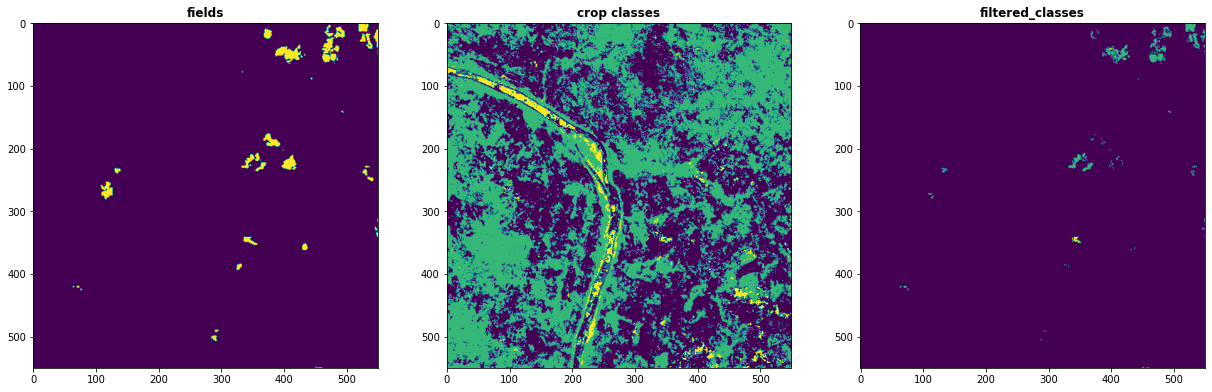

In [125]:
pred_arrays = [flds, pred, pred_filtered]  # combined into array
titles = ["fields", "crop classes", "filtered_classes"]
fig, axes = plt.subplots(1, len(pred_arrays), figsize=(21,14))
for i in range(len(axes)):
    parr = pred_arrays[i] 
    if i == 0: 
        parr = parr > 0
    show(parr, ax = axes[i], title = titles[i])

This example has very few fields detected, so the filtering removes many predictions that are false because they fall outside of fields.

That concludes the demonstration. This notebook provides a worked example of the steps that will be followed in the command line-based implementation.